# Imports and installations

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [53]:
import json
import random
from tqdm.notebook import trange, tqdm
import numpy as np
import pandas as pd
import os

from collections import Counter

from nltk.corpus import stopwords
stops = stopwords.words('russian')

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score

import torch
from torch.utils.data import Dataset, DataLoader

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
drive_path = '/content/drive/MyDrive/nnlp/word2vec'

# Download data: hw corpus

In [6]:
!wget https://github.com/semensorokin/DL-for-NLP/raw/year22-23/HW%231/data/processed_corpus.json.zip

--2022-11-16 17:18:15--  https://github.com/semensorokin/DL-for-NLP/raw/year22-23/HW%231/data/processed_corpus.json.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/semensorokin/DL-for-NLP/year22-23/HW%231/data/processed_corpus.json.zip [following]
--2022-11-16 17:18:16--  https://raw.githubusercontent.com/semensorokin/DL-for-NLP/year22-23/HW%231/data/processed_corpus.json.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3052590 (2.9M) [application/zip]
Saving to: ‘processed_corpus.json.zip’

processed_corpus.js 100%[===================>]   2.91M  --.-KB/s    in 0.01s   

2022-11-16 17:18:

In [7]:
import zipfile
with zipfile.ZipFile('processed_corpus.json.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [8]:
with open('data/processed_corpus.json') as f:
    corpus = json.load(f)

# Getting vocab

Кажется, имеет смысл взять границу в 3, ятобы иметь какую-то значащую разницу с предыдущим вариантом

In [9]:
vocab = set()
for sent in corpus:
    vocab.update(sent)
vocab = list(vocab)

In [10]:
word2index = {token: i for i, token in enumerate(vocab)}

In [11]:
len(word2index)

13076

# Dataset

In [12]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE
        
        # вставить здесь функцию, которые вы писали раньше

        splits = []
        for i in range(len(tokenized_text)):
            cur_tok = tokenized_text[i]
            tok = tokenized_text[max(0, i - self.window):i] + \
                    tokenized_text[i + 1: min(i + self.window + 1, len(tokenized_text))]
            for t in tok:
                splits.append((t, cur_tok))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        context, central_word = self.data[idx]
        context = torch.Tensor([context, ]).long()

        return context, central_word

# Model

In [34]:
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

In [33]:
class SkipGramSoft(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
        self.softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        x = self.softmax(x)
        
        return x

# Training Class

In [14]:
class TrainModel:
    def __init__(self, model, opt, loss, device):
        self.model = model
        self.opt = opt
        self.loss = loss
        self.device = device
        self.losses = []

    def fit(self, data, n_epoch=3):
        self.model.to(device)
        self.model.train(True)

        for epoch in trange(n_epoch, desc='Epochs'):
            progress_bar = tqdm(total=len(data), desc=f'Epoch {epoch + 1}')
            
            for x, y in data:
                x = x.to(device)
                y = y.to(device)

                self.opt.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.opt.step()  

                self.losses.append(loss.item())
            
                progress_bar.set_postfix(loss=np.mean(self.losses[-100:]))

                progress_bar.update(1)

            progress_bar.close()

        self.model.train(False)
        self.model.to('cpu')

# Similarity function

In [15]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Creating dataset

In [16]:
dataset = SkipgramDataset(corpus, word2index, window=3, unk_token='UNK')

  0%|          | 0/100000 [00:00<?, ?it/s]

# Base model

In [82]:
EMBEDDING_DIM = 20

In [83]:
BATCH_SIZE = 512

In [84]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [85]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [86]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [87]:
trainer = TrainModel(model, optimizer, criterion, device)

In [88]:
trainer.fit(dataset_loader, n_epoch=3)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/8154 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/8154 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/8154 [00:00<?, ?it/s]

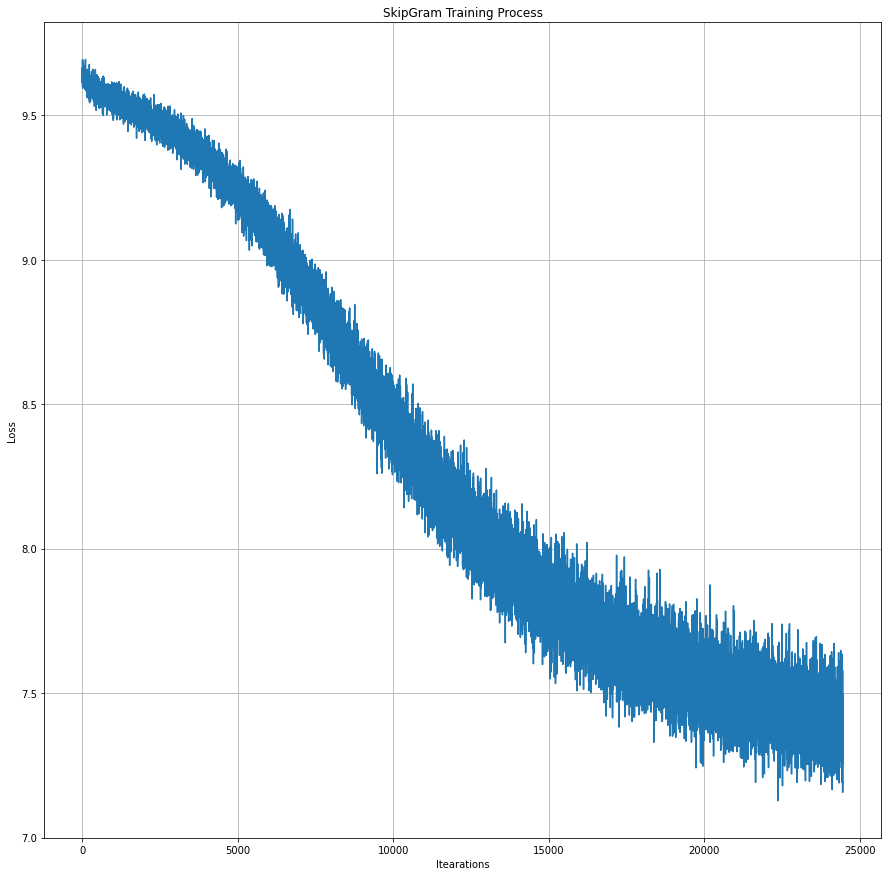

In [89]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(np.array(trainer.losses))

In [90]:
# проверка, что хоть что-то выучилось
assert np.mean(trainer.losses[-1000:]) < 7.5

К сожалению, до 7.5 вечно немного не дотягивает (а иногда дотягивает, как сейчас)

In [91]:
torch.save(model, f'{drive_path}/model_base.bin')

# Base model with higher dim
More epochs as it's more difficult to learn 100 floats

In [103]:
EMBEDDING_DIM = 100

In [104]:
BATCH_SIZE = 512

In [105]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [106]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [107]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [108]:
trainer = TrainModel(model, optimizer, criterion, device)

In [109]:
trainer.fit(dataset_loader, n_epoch=5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/8154 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/8154 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/8154 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/8154 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/8154 [00:00<?, ?it/s]

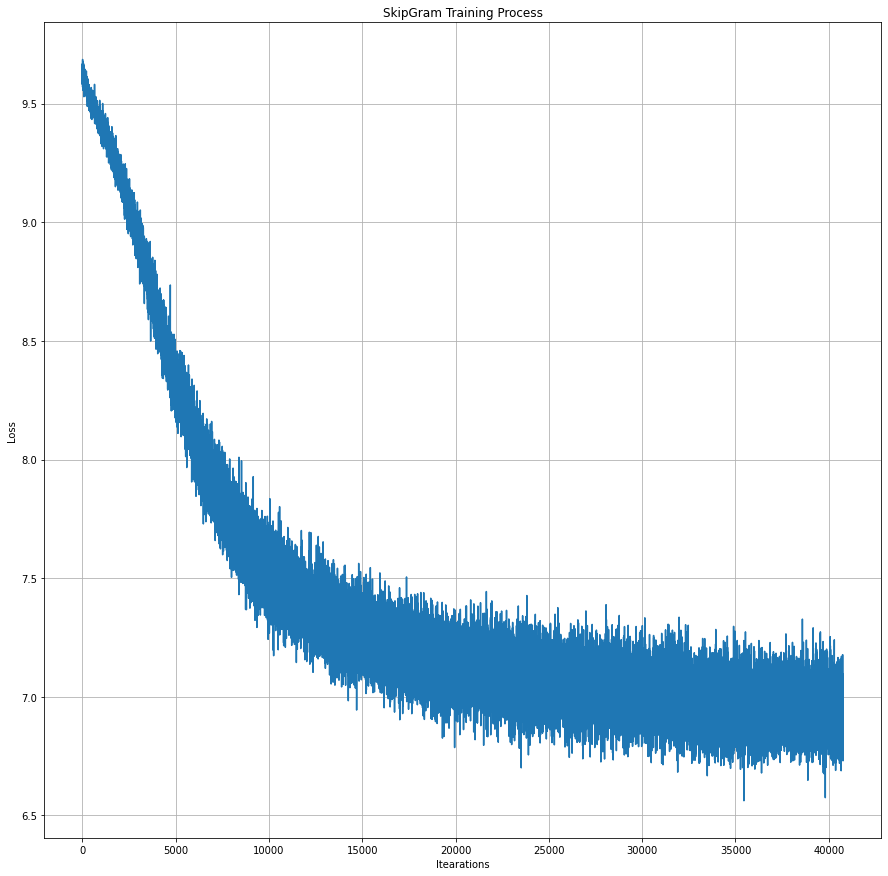

In [110]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(np.array(trainer.losses))

In [111]:
# проверка, что хоть что-то выучилось
assert np.mean(trainer.losses[-1000:]) < 7.5

In [112]:
torch.save(model, f'{drive_path}/model_base_dim100.bin')

# Base model with higher dim (300)

In [113]:
EMBEDDING_DIM = 300

In [114]:
BATCH_SIZE = 512

In [115]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [116]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [117]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [118]:
trainer = TrainModel(model, optimizer, criterion, device)

In [119]:
trainer.fit(dataset_loader, n_epoch=5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/8154 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/8154 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/8154 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/8154 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/8154 [00:00<?, ?it/s]

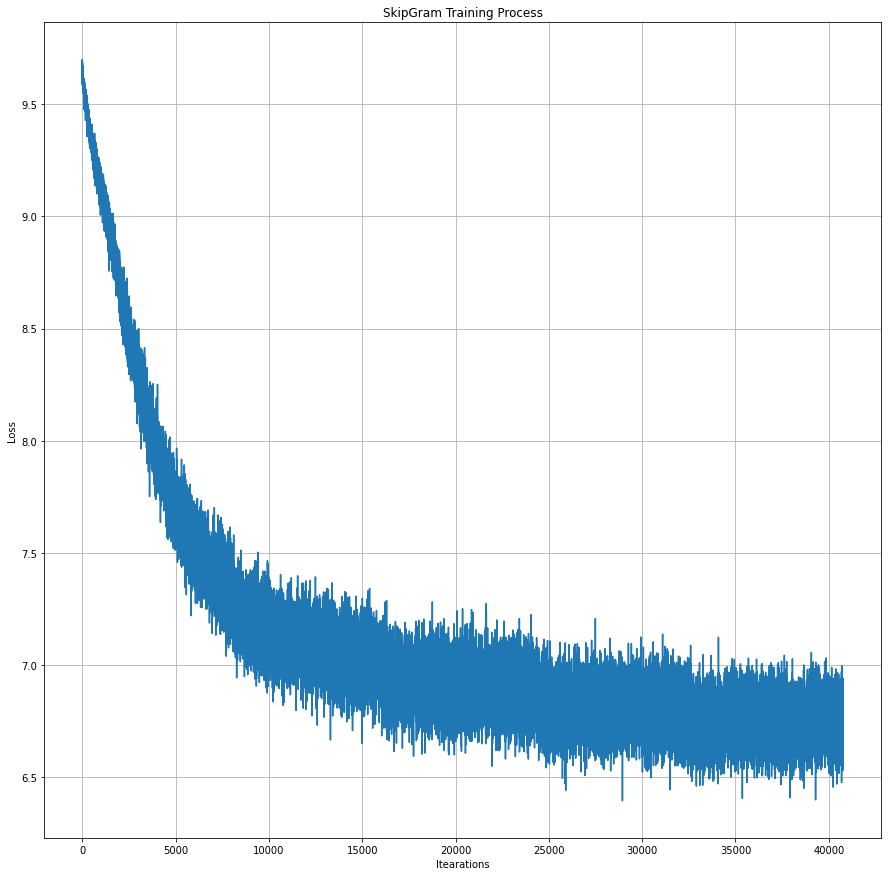

In [120]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(np.array(trainer.losses))

In [121]:
# проверка, что хоть что-то выучилось
assert np.mean(trainer.losses[-1000:]) < 7.5

In [122]:
torch.save(model, f'{drive_path}/model_base_dim300.bin')

# Training model with other different parameters

In [17]:
EMBEDDING_DIM = 100

In [18]:
BATCH_SIZE = 2048

In [19]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [20]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [21]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [22]:
trainer = TrainModel(model, optimizer, criterion, device)

In [23]:
trainer.fit(dataset_loader, n_epoch=3)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2039 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2039 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/2039 [00:00<?, ?it/s]

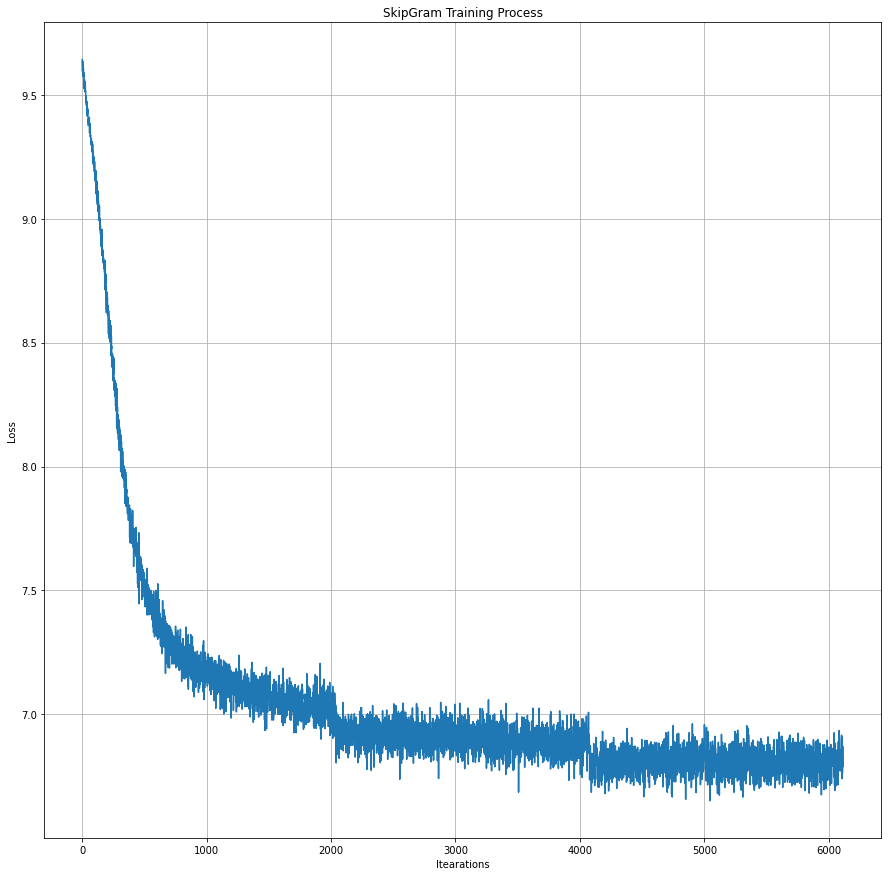

In [24]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(np.array(trainer.losses))

In [25]:
# проверка, что хоть что-то выучилось
assert np.mean(trainer.losses[-1000:]) < 7.5

In [26]:
torch.save(model, f'{drive_path}/model_base_diff.bin')

# Cosine similarity 

In [36]:
def count_cos(ms, w1, w2):
    res = []
    for m in ms:
        res.append(cos_sim(m, word2index, w1, w2))
    return res

In [35]:
embs = []
for el in l:
    m = torch.load(f'{drive_path}/{el}')
    embs.append(m.in_embedding.weight.detach())

In [30]:
l = os.listdir(drive_path)
l = [el for el in l if '.bin' in el]
l

['model_batch256.bin',
 'model_base_batch256.bin',
 'model_nll.bin',
 'model_base.bin',
 'model_base_lr3.bin',
 'model_base_dim100.bin',
 'model_base_dim300.bin',
 'model_base_diff.bin']

In [37]:
count_cos(embs, 'день', 'месяц')

[0.06017579138278961,
 0.06017579138278961,
 0.418641060590744,
 -0.45376408100128174,
 0.21474139392375946,
 0.01345299556851387,
 -0.028272144496440887,
 0.24453356862068176]

In [38]:
count_cos(embs, 'минута', 'месяц')

[-0.4102395176887512,
 -0.4102395176887512,
 0.09968322515487671,
 -0.06691873073577881,
 0.06840857863426208,
 0.007692303508520126,
 -0.08810938149690628,
 0.20786401629447937]

In [39]:
count_cos(embs, 'сотрудник', 'сотрудница')

[0.03370203077793121,
 0.03370203077793121,
 -0.03669869899749756,
 -0.42497339844703674,
 0.270324170589447,
 -0.0402572862803936,
 0.08833853155374527,
 0.15503057837486267]

In [40]:
count_cos(embs, 'вклад', 'перевод')

[-0.13882049918174744,
 -0.13882049918174744,
 -0.3423919677734375,
 0.20436733961105347,
 -0.014381550252437592,
 -0.01136452704668045,
 -0.022198153659701347,
 0.04916913062334061]

In [41]:
count_cos(embs, 'берег', 'математика')

[0.22036848962306976,
 0.22036848962306976,
 -0.006693623960018158,
 -0.15280118584632874,
 -0.3235609531402588,
 -0.09562535583972931,
 -0.006358686834573746,
 -0.0005620121955871582]

In [42]:
count_cos(embs, 'кошка', 'математика')

[-0.13420972228050232,
 -0.13420972228050232,
 0.2033746838569641,
 0.002108875662088394,
 0.05801934376358986,
 -0.2349524199962616,
 -0.005784796550869942,
 0.04180213063955307]

In [43]:
random_word = random.choice(list(word2index.keys()))
sim = count_cos(embs, 'день', random_word)
print('день', random_word, sim)

день сдуру [0.3694598376750946, 0.3694598376750946, -0.037184759974479675, 0.20504678785800934, -0.010375645011663437, -0.017507757991552353, -0.030280426144599915, 0.14915969967842102]


## Clustering

In [50]:
def get_clusters(emb, inds, vocab):
    res = pd.DataFrame()
    res['words'] = vocab[inds]
    for i, em in enumerate(emb):
        kmeans = KMeans(n_clusters=10, random_state=0)
        kmeans.fit(em[inds])
        labs = kmeans.labels_
        res[l[i]] = labs
    return res

In [44]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [45]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]
top_words = [a for a,_ in top_sorted_freq]
inds = [word2index[word] for word in top_words]

In [49]:
inds = np.array(inds)
vocab = np.array(vocab)

In [52]:
df = get_clusters(embs, inds, vocab)
df

,words,model_batch256.bin,model_base_batch256.bin,model_nll.bin,model_base.bin,model_base_lr3.bin,model_base_dim100.bin,model_base_dim300.bin,model_base_diff.bin
0,##число,7,7,7,2,2,7,9,0
1,банк,6,6,8,4,3,7,4,0
2,карта,2,2,8,7,7,0,1,0
3,UNK,6,6,5,4,8,8,4,0
4,кредит,4,4,0,7,7,8,1,2
...,...,...,...,...,...,...,...,...,...
195,друг,5,5,1,8,1,6,1,8
196,связь,2,2,5,5,6,8,6,0
197,предложение,5,5,2,7,2,1,3,8
198,онлайн,7,7,2,7,2,3,1,5


In [56]:
def count_homogen(df):
    res = []
    for el in l:
        res.append([el, ])
        for el1 in l:
            res[-1].append(homogeneity_score(df[el], df[el1]))
    res = pd.DataFrame(res, columns=['name',] + l)
    return res

In [57]:
count_homogen(df)

,name,model_batch256.bin,model_base_batch256.bin,model_nll.bin,model_base.bin,model_base_lr3.bin,model_base_dim100.bin,model_base_dim300.bin,model_base_diff.bin
0,model_batch256.bin,1.000000,1.000000,0.105103,0.095178,0.108568,0.112244,0.099615,0.085412
1,model_base_batch256.bin,1.000000,1.000000,0.105103,0.095178,0.108568,0.112244,0.099615,0.085412
2,model_nll.bin,0.106296,0.106296,1.000000,0.101538,0.126133,0.095269,0.116447,0.099910
3,model_base.bin,0.094211,0.094211,0.099379,1.000000,0.120493,0.120353,0.104646,0.114430
4,model_base_lr3.bin,0.107725,0.107725,0.123749,0.120783,1.000000,0.099702,0.120248,0.109624
5,model_base_dim100.bin,0.118338,0.118338,0.099314,0.128189,0.105937,1.000000,0.105674,0.108448
6,model_base_dim300.bin,0.107602,0.107602,0.124371,0.114195,0.130905,0.108268,1.000000,0.093182
7,model_base_diff.bin,0.093972,0.093972,0.108688,0.127189,0.121554,0.113172,0.094911,1.000000


## Evaluation
Очень странно, но пусть остается, потому что выглядит забавно

In [59]:
!wget https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv

--2022-11-16 17:47:02--  https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv
Resolving rusvectores.org (rusvectores.org)... 172.104.228.108
Connecting to rusvectores.org (rusvectores.org)|172.104.228.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42924 (42K) [text/tab-separated-values]
Saving to: ‘ru_simlex965_tagged.tsv’

ru_simlex965_tagged 100%[===================>]  41.92K  --.-KB/s    in 0.09s   

2022-11-16 17:47:03 (457 KB/s) - ‘ru_simlex965_tagged.tsv’ saved [42924/42924]



In [60]:
simlex = pd.read_csv('ru_simlex965_tagged.tsv', sep='\t')
cols = simlex.columns.tolist()
cols[0] = 'Word1'
simlex.columns = cols
simlex.head()

,Word1,Word2,Average Score
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77
3,автомобиль_NOUN,гудок_NOUN,1.85
4,автомобиль_NOUN,автострада_NOUN,1.23


In [61]:
av = simlex['Average Score'].to_numpy()
av = av / av.max()
simlex['av_norm'] = av
simlex.head()

,Word1,Word2,Average Score,av_norm
0,авария_NOUN,бедствие_NOUN,6.15,0.615
1,август_NOUN,месяц_NOUN,2.85,0.285
2,авиация_NOUN,полет_NOUN,6.77,0.677
3,автомобиль_NOUN,гудок_NOUN,1.85,0.185
4,автомобиль_NOUN,автострада_NOUN,1.23,0.123


In [62]:
simlex['word1_split'] = simlex['Word1'].apply(lambda x: x.split('_')[0])
simlex['word2_split'] = simlex['Word2'].apply(lambda x: x.split('_')[0])
simlex.head()

,Word1,Word2,Average Score,av_norm,word1_split,word2_split
0,авария_NOUN,бедствие_NOUN,6.15,0.615,авария,бедствие
1,август_NOUN,месяц_NOUN,2.85,0.285,август,месяц
2,авиация_NOUN,полет_NOUN,6.77,0.677,авиация,полет
3,автомобиль_NOUN,гудок_NOUN,1.85,0.185,автомобиль,гудок
4,автомобиль_NOUN,автострада_NOUN,1.23,0.123,автомобиль,автострада


In [63]:
def count_cos_sim(x, em):
    if (x[0] in word2index) and (x[1] in word2index):
        return cos_sim(em, word2index, x[0], x[1])
    else:
        return None

In [65]:
for i, el in enumerate(l):
    simlex[f'cos_norm_{el}'] = simlex[['word1_split', 'word2_split']].apply(count_cos_sim, em=embs[i], axis=1)
    simlex = simlex.dropna()

In [66]:
simlex.head()

,Word1,Word2,Average Score,av_norm,word1_split,word2_split,cos_norm_model_batch256.bin,cos_norm_model_base_batch256.bin,cos_norm_model_nll.bin,cos_norm_model_base.bin,cos_norm_model_base_lr3.bin,cos_norm_model_base_dim100.bin,cos_norm_model_base_dim300.bin,cos_norm_model_base_diff.bin
1,август_NOUN,месяц_NOUN,2.85,0.285,август,месяц,0.090989,0.090989,0.229736,0.187656,0.266052,-0.194263,-0.027345,0.051855
3,автомобиль_NOUN,гудок_NOUN,1.85,0.185,автомобиль,гудок,-0.297262,-0.297262,-0.370662,-0.520070,0.004933,-0.008861,0.144936,0.052955
5,автомобиль_NOUN,такси_NOUN,4.15,0.415,автомобиль,такси,0.194012,0.194012,0.155813,-0.038248,0.143798,0.017800,0.072019,0.196049
7,автомобиль_NOUN,велосипед_NOUN,1.38,0.138,автомобиль,велосипед,-0.199532,-0.199532,0.101599,0.163785,0.047324,-0.045527,0.092280,0.017700
9,автомобиль_NOUN,мост_NOUN,1.15,0.115,автомобиль,мост,0.150756,0.150756,-0.012453,0.141695,0.060984,0.050655,-0.057962,0.045805


In [67]:
for el in l:
    print(el, mean_squared_error(simlex.av_norm, simlex[f'cos_norm_{el}']))

model_batch256.bin 0.24454568588531528
model_base_batch256.bin 0.24454568588531528
model_nll.bin 0.23909917520351728
model_base.bin 0.25326340154541255
model_base_lr3.bin 0.17664447890576088
model_base_dim100.bin 0.20235119815623653
model_base_dim300.bin 0.20277985324624587
model_base_diff.bin 0.18163853913135963


In [69]:
simlex.corr()['av_norm']

Average Score                       1.000000
av_norm                             1.000000
cos_norm_model_batch256.bin        -0.057666
cos_norm_model_base_batch256.bin   -0.057666
cos_norm_model_nll.bin              0.063525
cos_norm_model_base.bin            -0.006076
cos_norm_model_base_lr3.bin         0.026121
cos_norm_model_base_dim100.bin      0.002167
cos_norm_model_base_dim300.bin     -0.008389
cos_norm_model_base_diff.bin       -0.055151
Name: av_norm, dtype: float64

В общем, тут все тоже плохо, но я решила сдать, чтобы усилия свосем зря не пропали (